 PIPELINE 1B: RANDOM FOREST

1. Preparazione dati...
✓ Dataset preparato: (354766, 5)
  Distribuzione target: {1: 179774, 0: 174992}

2. Split dati...
✓ Train: 248335, Val: 35477, Test: 70954

4. Training Random Forest...
✓ Random Forest completato
  Best params: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200}
  F1-Score Test: 0.6619
  Accuracy:  0.6870
  Precision:  0.7312
  Recall:  0.6045


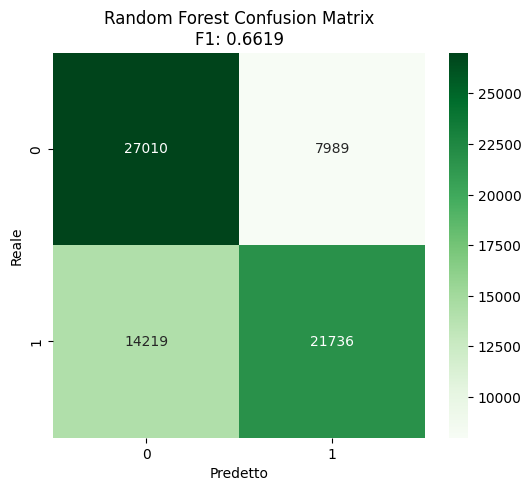


✅ PIPELINE 1 COMPLETATA!


In [4]:
# Pipeline 1B - Random Forest Tree
import ast
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

print("=" * 80)
print(" PIPELINE 1B: RANDOM FOREST")
print("=" * 80)

# === DATA PREPARATION ===
print("\n1. Preparazione dati...")
dataset = pd.read_csv('blackjack_simulator.csv')

# Discretizzazione target
condizioni = [
    (dataset['win'] > 0),
    (dataset['win'] == 0),
    (dataset['win'] < 0)
]
valori_target = [1, 0, -1]
dataset['win'] = np.select(condizioni, valori_target)

# Rimozione colonne
to_drop = [
    "shoe_id", "dealer_final", "dealer_final_value",
    "player_final", "player_final_value", "actions_taken",
    "run_count", "true_count", "cards_remaining"
]
dataset = dataset.drop(columns=to_drop, errors="ignore")

# Funzioni helper
def parse_hand(x):
    if isinstance(x, list): return x
    if isinstance(x, str):
        try:
            parsed = ast.literal_eval(x)
            return parsed if isinstance(parsed, list) else []
        except: return []
    return []

def card_value(card):
    if isinstance(card, (int, float)): return int(card)
    c = str(card).strip().upper()
    if c in {"J", "Q", "K"}: return 10
    if c == "A": return 11
    try: return int(c)
    except: return 0

def hand_value_and_soft(hand):
    values = []
    aces_total = 0
    for c in hand:
        if str(c).strip().upper() == "A": aces_total += 1
        values.append(card_value(c))
    total = sum(values)
    aces_left = aces_total
    while total > 21 and aces_left > 0:
        total -= 10
        aces_left -= 1
    is_soft = 1 if aces_left < aces_total else 0
    return total, is_soft

# Feature engineering
dataset["initial_hand"] = dataset["initial_hand"].apply(parse_hand)
tmp = dataset["initial_hand"].apply(
    lambda h: hand_value_and_soft(h) if isinstance(h, list) else (0, 0)
)
dataset["player_sum"] = tmp.apply(lambda x: x[0]).astype(int)
dataset["player_is_soft"] = tmp.apply(lambda x: x[1]).astype(int)
dataset["player_pair"] = dataset["initial_hand"].apply(
    lambda h: 1 if isinstance(h, list) and len(h) == 2 and card_value(h[0]) == card_value(h[1]) else 0
).astype(int)
dataset["dealer_up"] = dataset["dealer_up"].apply(card_value).astype(int)

# Target binario
dataset["win_bin"] = (dataset["win"] >= 0).astype(int)

dataset_finale = dataset[
    ["player_sum", "player_is_soft", "player_pair", "dealer_up", "win_bin"]
].copy()

print(f"✓ Dataset preparato: {dataset_finale.shape}")
print(f"  Distribuzione target: {dataset_finale['win_bin'].value_counts().to_dict()}")

# === SPLIT DATI ===
print("\n2. Split dati...")
X = dataset_finale[["player_sum", "player_is_soft", "player_pair", "dealer_up"]]
y = dataset_finale["win_bin"]

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp
)

print(f"✓ Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

# === RANDOM FOREST ===
print("\n4. Training Random Forest...")
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [15, 20],
    'min_samples_split': [2, 5]
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='f1', n_jobs=-1, verbose=0)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
y_test_pred_rf = best_rf.predict(X_test)
f1_rf = f1_score(y_test, y_test_pred_rf)
acc_rf = accuracy_score(y_test, y_test_pred_rf)
rec_rf = recall_score(y_test, y_test_pred_rf)
pre_rf = precision_score(y_test, y_test_pred_rf)

print(f"✓ Random Forest completato")
print(f"  Best params: {grid_rf.best_params_}")
print(f"  F1-Score Test: {f1_rf:.4f}")
print(f"  Accuracy:  {acc_rf:.4f}")
print(f"  Precision:  {pre_rf:.4f}")
print(f"  Recall:  {rec_rf:.4f}")

# Visualizzazione (Solo 1 grafico)
plt.figure(figsize=(6, 5))
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title(f'Random Forest Confusion Matrix\nF1: {f1_rf:.4f}')
plt.ylabel('Reale')
plt.xlabel('Predetto')
plt.show()

print("\n" + "=" * 80)
print("✅ PIPELINE 1 COMPLETATA!")
print("=" * 80)
